# Custom modules

In [1]:
import os
import sys
# lib_src = os.path.join(os.getcwd(), os.pardir, 'src')
lib_src = '\\Users\\mauricio\\gdrive\\python\\machine-learning'
sys.path.insert(1, lib_src)

In [2]:
from dummies import get_dummies_indices
from metrics.log_loss import multi_multi_log_loss
from preprocessing.combine_text_columns import combine_text_columns
from model_selection.multilabel import multilabel_sample_dataframe, multilabel_train_test_split
from size import size
from to_csv_to_zip import to_csv_to_zip
from fit_cache import fit_cache

# Standard modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
from datetime import datetime
import warnings
from zipfile import ZipFile, ZIP_DEFLATED
import psutil
from tempfile import mkdtemp
from shutil import rmtree

%matplotlib inline

# Load data, randomize, optimize category type and get dummy labels

In [4]:
prediction_dir = '/Users/mauricio/Documents/predictions/'
model_dir = '/Users/mauricio/Documents/models/'
df = pd.read_csv('../data/TrainingData.csv', index_col=0)
df = df.sample(frac=1, random_state=1)
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
FEATURES = [feature for feature in df.columns if feature not in LABELS]
NUMERIC_FEATURES = ['FTE', 'Total']
TEXT_FEATURES = [text_feature for text_feature in FEATURES if text_feature not in NUMERIC_FEATURES]
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
y = pd.get_dummies(df[LABELS], prefix_sep='__')
holdout = pd.read_csv('../data/TestData.csv', index_col=0, dtype={'Facility_or_Department':'object', 'Text_4':'object'})
holdout = holdout[FEATURES]

# Model metric: multi-multi log loss

In [5]:
from sklearn.metrics import make_scorer
cci = get_dummies_indices(df[LABELS])
multi_multi_log_loss_scorer = make_scorer(multi_multi_log_loss, greater_is_better=False, needs_proba=True,
                                          class_column_indices=cci)

# Candidate classifiers

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Baseline pipeline

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, PolynomialFeatures

In [8]:
from preprocessing.get_normalized_total import get_normalized_total
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': NUMERIC_FEATURES + LABELS})
get_numeric_data = FunctionTransformer(get_normalized_total, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total'})

In [9]:
pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', Pipeline([
            ('numeric_selector', get_numeric_data),
            ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0))
        ], verbose=True)),
        ('text_features' , Pipeline([
            ('text_selector', get_text_data),
            ('vectorizer', HashingVectorizer(norm = None, binary = False, alternate_sign = False, dtype = 'uint8')),
            ('reducer', SelectKBest(score_func = chi2))
        ], verbose=True))
    ])),
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', MaxAbsScaler()),
    ('classifier', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
], verbose=True)

# Learning and validation curves

In [10]:
from model_selection.learning_curve import plot_learning_curve
from model_selection.validation_curve import plot_validation_curve
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer

train_sizes = np.linspace(0.2, 1, 5)

The learning curves help comparing algorithms for bias-variance behavior, choosing model parameters during design, adjusting optimization to improve convergence and determining the amount of data used for training.

In this pipeline, the amount of data is determined not only by the sample size, but also by:
* the feature generation step `HashingVectorizer` with its parameter `ngram_range`.
* the feature selection step `SelectKBest(chi2)` with its parameter `k`.
* the feature generation step `PolynomialFeatures` with its parameters fixed.

Initially, it's picked main classification algorithms that support specific characteristics of the pipeline:
* Sparse data produced by the `HashingVectorizer` 
* Negative numbers present in the numeric features `Total`and `FTE`.

Because of this characteristics, alghorithms such as Naive Bayes can't be used:
* `GaussianNB` requires dense data
* `MultinomialNB` requires positive numbers.

Other alghorithms were much slow hence it's limited to `LogisticRegression`.  This limitation is expected to be removed in a future version.

The train sizes is a sligthly variation of the [default](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve) `np.linspace(0.1, 1.0, 5)` to keep evenly spaced intervals.

# 1% data sample

In [11]:
sampling = multilabel_sample_dataframe(df, y, size=0.01, min_count=7, seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
print('Sample size:', sampling.shape[0])                                    # 4002
print('Train sizes:', (sampling.shape[0] * train_sizes * .8).astype('int')) # [640 1280 1920 2561 3201]
print('Test sizes :', (sampling.shape[0] * train_sizes * .2).astype('int')) # [160 320 480 640 800]

Sample size: 4002
Train sizes: [ 640 1280 1920 2561 3201]
Test sizes : [160 320 480 640 800]


## Learning curves

In [12]:
classifiers = [#('Dummy (uniform)', OneVsRestClassifier(DummyClassifier(strategy='uniform'))),
               ('Logistic regression', OneVsRestClassifier(LogisticRegression(solver='liblinear')))#,
               #('SVC', OneVsRestClassifier(SVC(probability=True))),
               #('xgboost', OneVsRestClassifier(XGBClassifier())),
               #('GBM', OneVsRestClassifier(GradientBoostingClassifier())),  # mostly slower/worse thanxgboost
               #('Random Forest', OneVsRestClassifier(RandomForestClassifier())),
               #('K-Neighbors', OneVsRestClassifier(KNeighborsClassifier()))
              ]

Finding the`k` parameter space limits for each `ngram_range`

In [13]:
ngram_kmax = [len(CountVectorizer(ngram_range=(1,n),
                                  dtype='uint8').fit(combine_text_columns(sampling)).vocabulary_)
              for n in range(1, 4)]  # [1546, 8703, 19981]

### 1-gram features

2020-07-01T04:38


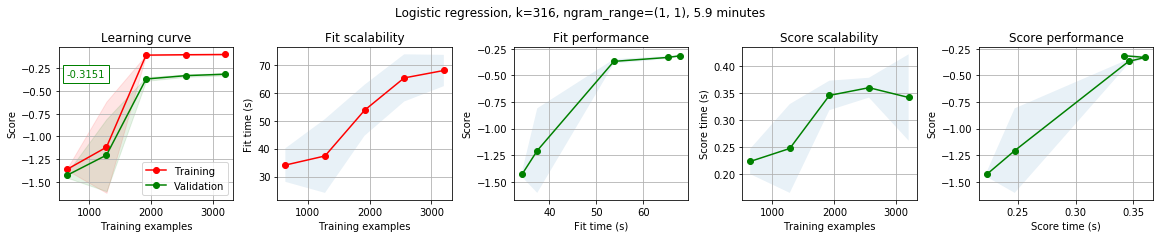

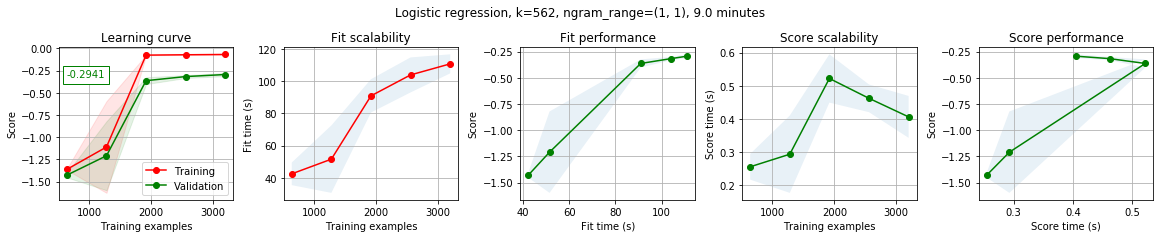

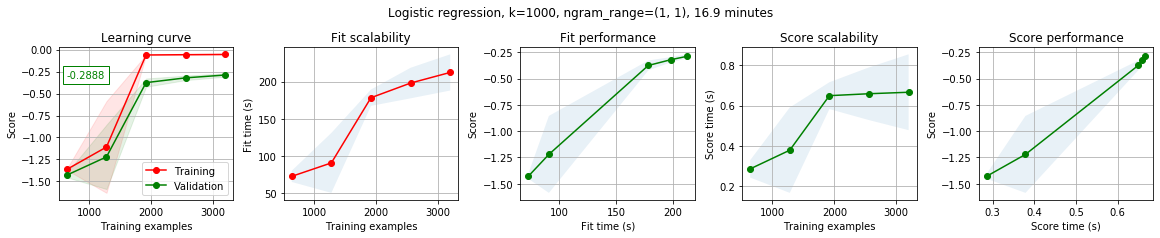

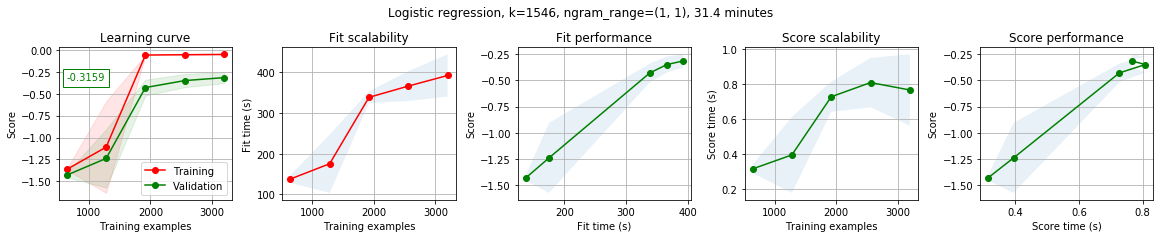

In [18]:
ngram1_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_kmax[0])), 7).round().astype('int')
ngram1_logspace = np.hstack((ngram1_logspace[ngram1_logspace < ngram_kmax[0]], ngram_kmax[0]))
parameters = ParameterGrid([{'union__text_features__vectorizer__ngram_range': [(1,1)],
                             'union__text_features__reducer__k': ngram1_logspace}]) # [316, 562, 1000, 1546]
print(datetime.now().isoformat(timespec='minutes'))
for title, classifier in classifiers:
    pl.set_params(classifier = classifier)
    pl.set_params(classifier__n_jobs = None)
    for parameter in parameters:
        pl.set_params(**parameter)
        plot_learning_curve(pl, ', '.join([title] + [k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            sampling[FEATURES], dummy_labels, cv=5, scoring=multi_multi_log_loss_scorer,
                            n_jobs=-1, #verbose=11,
                            train_sizes=train_sizes)
        plt.show()

### 2-gram features

With 2-gram features it was only possible to run without parallel processing within `plot_learning_curve()` (`n_jobs=None`) but still possible to do some parallel processing in the pipelines's classifier step `OneVsRestClassifier()` (`n_jobs=2`) but not possible to parallelize when `k=5623`.  2-gram features predict worse than 1-gram features.  

The intended `k` parameter space:

In [19]:
ngram2_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_kmax[1])), 7).round().astype('int')
ngram2_logspace = np.hstack((ngram2_logspace[ngram2_logspace < ngram_kmax[1]], ngram_kmax[1]))
parameters = ParameterGrid([{'union__text_features__vectorizer__ngram_range': [(1,2)],
                             'union__text_features__reducer__k': [316, 562, 1000, 1778, 3162]}]) # ngram2_logspace}])
print(datetime.now().isoformat(timespec='minutes'))
for title, classifier in classifiers:
    pl.set_params(classifier = classifier)
    pl.set_params(classifier__n_jobs = None)
    for parameter in parameters:
        pl.set_params(**parameter)
        plot_learning_curve(pl, ', '.join([title] + [k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            sampling[FEATURES], dummy_labels, cv=5, scoring=multi_multi_log_loss_scorer,
                            n_jobs=2, verbose=11, train_sizes=train_sizes)
        plt.show()

array([ 316,  562, 1000, 1778, 3162, 5623, 8703])

In order advance to end of the `k` parameter space, the training was run without any parallelism (`n_jobs=None`) for the `plot_learning_curve()` and the pipelines's classifier step `OneVsRestClassifier()`.

In [ ]:
parameters = ParameterGrid([{'union__text_features__vectorizer__ngram_range': [(1,2)],
                             'union__text_features__reducer__k': [5623]}]) # ngram2_logspace}])
print(datetime.now().isoformat(timespec='minutes'))
for title, classifier in classifiers:
    pl.set_params(classifier = classifier)
    pl.set_params(classifier__n_jobs = None)
    for parameter in parameters:
        pl.set_params(**parameter)
        plot_learning_curve(pl, ', '.join([title] + [k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            sampling[FEATURES], dummy_labels, cv=5, scoring=multi_multi_log_loss_scorer,
                            n_jobs=None, verbose=11, train_sizes=train_sizes)
        plt.show()

Even without the parallelism, the limit of the `k` parameter space (8703) wasn't reached because the training ran out of memory.

In [ ]:
parameters = ParameterGrid([{'union__text_features__vectorizer__ngram_range': [(1,2)],
                             'union__text_features__reducer__k': [8703]}]) # ngram2_logspace}])
print(datetime.now().isoformat(timespec='minutes'))
for title, classifier in classifiers:
    pl.set_params(classifier = classifier)
    pl.set_params(classifier__n_jobs = None)
    for parameter in parameters:
        pl.set_params(**parameter)
        plot_learning_curve(pl, ', '.join([title] + [k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            sampling[FEATURES], dummy_labels, cv=5, scoring=multi_multi_log_loss_scorer,
                            n_jobs=None, verbose=11, train_sizes=train_sizes)
        plt.show()

### 3-gram features

Because of the results of 2-gram features compared to 1-gram features, it wasn't expected better results with 3-gram features which also suffers from lack of memory.

In [ ]:
ngram3_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_kmax[2])), 11).round().astype('int')
ngram3_logspace = np.hstack((ngram3_logspace[ngram3_logspace < ngram_kmax[2]], ngram_kmax[2]))
parameters = ParameterGrid([{'union__text_features__vectorizer__ngram_range': [(1,3)],
                             'union__text_features__reducer__k': ngram3_logspace}])  # 
print(datetime.now().isoformat(timespec='minutes'))
for title, classifier in classifiers:
    pl.set_params(classifier = classifier)
    pl.set_params(classifier__n_jobs = None)
    for parameter in parameters:
        pl.set_params(**parameter)
        plot_learning_curve(pl, ', '.join([title] + [k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            sampling[FEATURES], dummy_labels, cv=5, scoring=multi_multi_log_loss_scorer,
                            n_jobs=None, verbose=11, train_sizes=train_sizes)
        plt.show()

### Metrics summary

| sample | min | jobs | features | ngram | train_sizes |    k | interact | logloss|      time |     peak|
| -----: | --: | ---: | -------: | ----: | ----------: | ---: | -------: | ------:| --------: |  ------:|
|   0.01 |   7 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) |  316 |    51681 | 0.3151 |   5.9 min | 2.2 GiB |
|   0.01 |   7 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) |  562 |   159330 | 0.2941 |   9.1 min | 2.2 GiB |
|   0.01 |   7 |    4 |  2\*\*20 | **(1,1)** | (0.2, 1, 5) | **1000** |   **505515** | **0.2888** |  16.9 min | 2.3 GiB |
|   0.01 |   7 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | 1546 |  1203576 | 0.3159 |  31.1 min | 2.3 GiB |
|   0.01 |   7 |    4 |  2\*\*20 | (1,2) | (0.2, 1, 5) |  316 |    51681 | 0.3880 |   6.4 min | 2.3 GiB |
|   0.01 |   7 |    4 |  2\*\*20 | (1,2) | (0.2, 1, 5) |  562 |   159330 | 0.3438 |  14.7 min | 2.2 GiB |
|   0.01 |   7 |    4 |  2\*\*20 | (1,2) | (0.2, 1, 5) | 1000 |   505515 | 0.3210 |  33.6 min | 2.2 GiB |
|   0.01 |   7 |    4 |  2\*\*20 | (1,2) | (0.2, 1, 5) | 1778 |  1590436 | 0.3139 | 102.4 min | 2.3 GiB |
|   0.01 |   7 |    4 |  2\*\*20 | (1,2) | (0.2, 1, 5) | 3162 |  5016528 | 0.3098 | 228.6 min | 4.6 GiB |
|   0.01 |   7 |    1 |  2\*\*20 | (1,2) | (0.2, 1, 5) | 5623 | 15840006 | 0.3250 | 589.6 min |  14 GiB |
|   0.01 |   7 |    1 |  2\*\*20 | (1,2) | (0.2, 1, 5) | 8703 | 37918986 | |  |  |

The best parameter set is `k=1000` and `ngram_range=(1,1)`

## Regularization validation curve

C is the inverse of regularization strength, therefore, greater values specify weaker regularization.

Started 2020-07-01T11:44


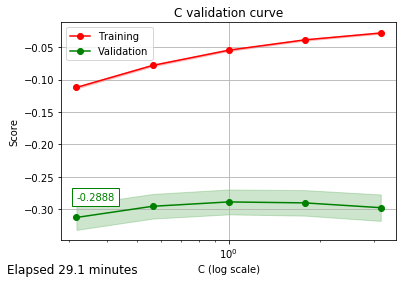

In [20]:
pl.set_params(union__text_features__vectorizer__ngram_range = (1,1),
              union__text_features__reducer__k = 1000)
param_name='classifier__estimator__C'
param_range = np.logspace(-0.5, 0.5, 5)  # [0.31622777, 0.56234133, 1, 1.77827941, 3.16227766]
param_label = 'C'
plot_validation_curve(pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=-1, #verbose=11,
                      xscale='log')
plt.show()

Having `ngram_range=(1,1)` and `k=1000`, the best parameter is `C=1`, scoring `0.2888`, elapsed `29 minutes`

## Fit model and predict probabilities on holdout set

In [14]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')),
              classifier__n_jobs = -1,
              classifier__estimator__C = 1,
              union__text_features__vectorizer__ngram_range = (1,1),
              union__text_features__reducer__k = 1000)

model_name = '0.01-k1000-logistic-regression-C1'
pl = fit_cache(pl, sampling[FEATURES], dummy_labels, model_dir, model_name)
to_csv_to_zip(prediction_dir, model_name, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

Fitting started on 2020-07-01T14:55
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  18.4s
[Pipeline] ............. (step 1 of 4) Processing union, total=  18.6s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.1s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.1min
Done: 1.4 minutes
Saving cache 0.01-k1000-logistic-regression-C1 ... Done: 0.0 minutes
Saving CSV...Done: 0.2 minutes
Zipping...Done: 0.2 minutes


`ngram_range=(1,1)`, `k=1000` and `C=1`, elapsed `1.4 minutes`, DrivenData score: `0.5598`

# 10% data sample

In [11]:
sampling = multilabel_sample_dataframe(df, y, size=0.1, min_count=2, seed=1)
print('Sample size:', sampling.shape[0])                                     # 40027
print('Train sizes:', (sampling.shape[0] * train_sizes * .8).astype('int'))  # [6404 12808 19212 25617 32021]
print('Test sizes :', (sampling.shape[0] * train_sizes * .2).astype('int'))  # [1601 3202 4803 6404 8005]
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')

Sample size: 40027
Train sizes: [ 6404 12808 19212 25617 32021]
Test sizes : [1601 3202 4803 6404 8005]


## Learning curves for 1-gram features

In [12]:
classifiers = [
    ('Logistic regression (liblinear)', OneVsRestClassifier(LogisticRegression(solver='liblinear'))),
    #('Logistic regression (lbfgs)', OneVsRestClassifier(LogisticRegression(solver='lbfgs'))), # max_iter=200
    #('Logistic regression (sag)', OneVsRestClassifier(LogisticRegression(solver='sag'))), # max_iter=4000
    #('Logistic regression (saga)', OneVsRestClassifier(LogisticRegression(solver='saga'))), # max_iter=3200
    #('Logistic regression (newton-cg)', OneVsRestClassifier(LogisticRegression(solver='newton-cg')))
]

Finding the`k` parameter space limits for each `ngram_range`

In [13]:
ngram_kmax = [len(CountVectorizer(ngram_range=(1,n),
                                  dtype='uint8').fit(combine_text_columns(sampling)).vocabulary_)
              for n in range(1, 4)] # [2579, 18282, 46898]

The learning curves:

2020-07-03T13:15


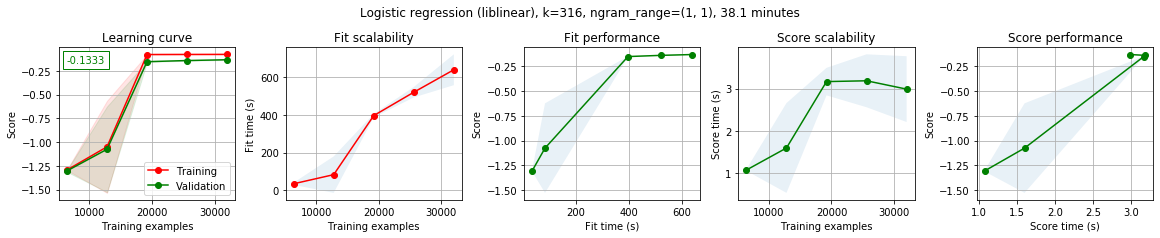

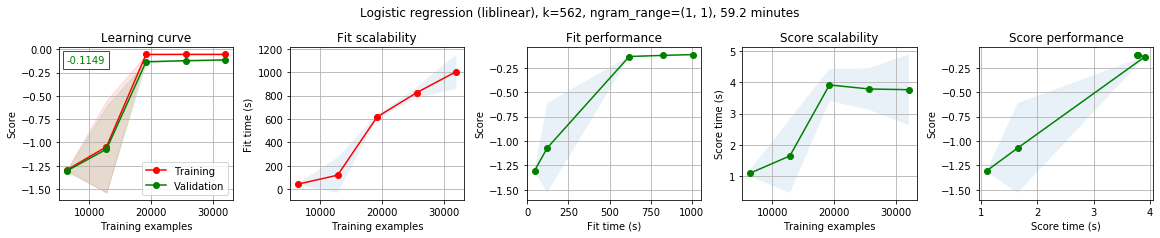

In [ ]:
ngram1_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_kmax[0])), 7).round().astype('int')
ngram1_logspace = np.hstack((ngram1_logspace[ngram1_logspace < ngram_kmax[0]], ngram_kmax[0]))
parameters = ParameterGrid([{'union__text_features__vectorizer__ngram_range': [(1,1)],
                             'union__text_features__reducer__k': ngram1_logspace}]) # [316, 562, 1000, 1778, 2579]
print(datetime.now().isoformat(timespec='minutes'))
for title, classifier in classifiers:
    pl.set_params(classifier = classifier)
    pl.set_params(classifier__n_jobs = None)
    for parameter in parameters:
        pl.set_params(**parameter)
        plot_learning_curve(pl, ', '.join([title] + [k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            sampling[FEATURES], dummy_labels, cv=5, scoring=multi_multi_log_loss_scorer,
                            n_jobs=-1, #verbose=11,
                            train_sizes=train_sizes)
        plt.show()

**Based on 2-gram's 1% sample training results, 2-gram range won't be further used.**

## Metrics summary

| sample | min | jobs | features | ngram | train_sizes |    k | interact | logloss|      time |      peak |
| -----: | --: | ---: | -------: | ----: | ----------: | ---: | -------: | -----: |  -------: | --------: |
|    0.1 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) |  316 |    51681 | 0.1333 |  38.6 min |    2.2 GiB|
|    0.1 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) |  562 |   161028 | 0.1149 |  58.5 min |    2.2 GiB|
|    0.1 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | 1000 |   505515 | 0.1065 |  85.9 min |    2.2 GiB|
|    0.1 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | **1778** |  1590436 | **0.1046** | 125.5 min |    3.1 GiB|
|    0.1 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | 2579 |  3339820 | 0.1121 | 180.8 min |    3.1 GiB|

The best parameter is `k=1778`

## Regularization validation curve **(TORUN)**

Started 2020-02-18T17:50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   5 | elapsed: 31.6min remaining: 126.3min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 31.7min remaining: 47.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 31.8min remaining: 21.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 42.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 42.4min finished


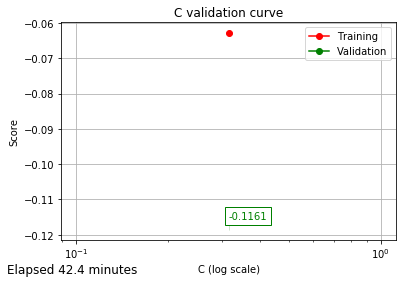

In [14]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')),
              union__text_features__vectorizer__ngram_range = (1,1),
              union__text_features__reducer__k = 1778)
param_name='classifier__estimator__C'
param_range = np.logspace(-1, 1, 9)  # [0.1,0.1778279410038923, 0.31622776601683794, 0.5623413251903491, 1,
                                     # 1.7782794100389228, 3.1622776601683795, 5.623413251903491, 10]
param_label = 'C'
plot_validation_curve(pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=-1, #verbose=11,
                      xscale='log')
plt.show()

Holding fixed `ngram_range=(1,1)` and `k=1778`, the best is `C=0.5623413251903491` (increasing the default regulariation), scoring `0.1041`, elapsed `hundreds of minutes`

## Fit model and predict probabilities on holdout set **(SUBMIT)**

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')),
              classifier__n_jobs = -1,
              classifier__estimator__C = 0.5623413251903491,
              union__text_features__vectorizer__ngram_range = (1,1),
              union__text_features__reducer__k = 1778)

model_name = '0.1-k1778-logistic-regression-C0.5623413251903491'
pl = fit_cache(pl, sampling[FEATURES], dummy_labels, model_dir, model_name)
to_csv_to_zip(prediction_dir, model_name, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

`ngram_range=(1,1)`, `k=1778` and `C=1`, elapsed `31.1 minutes`, DrivenData score: `0.4818`  
`ngram_range=(1,1)`, `k=1778` and `C=0.5623413251903491`, elapsed ` minutes`, DrivenData score: `0.???`

# 20% data sample

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.2, min_count = 2, seed = 1)
print('Sample size:', sampling.shape[0])                                     # 80055
print('Train sizes:', (sampling.shape[0] * train_sizes * .8).astype('int'))  # [12808 25617 38426 51235 64044]
print('Test sizes :', (sampling.shape[0] * train_sizes * .2).astype('int'))  # [3202  6404  9606 12808 16011]
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')

## Learning curves for 1-gram features

In [ ]:
classifiers = [
    ('Logistic regression (liblinear)', OneVsRestClassifier(LogisticRegression(solver='liblinear')))#, #fast4small
    #('Logistic regression (lbfgs)', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=200))), #fast4small
    #('Logistic regression (sag)', OneVsRestClassifier(LogisticRegression(solver='sag', max_iter=4000)))#, # faster?
    #('Logistic regression (saga)', OneVsRestClassifier(LogisticRegression(solver='saga', max_iter=3200))), #fast??
    #('Logistic regression (newton-cg)', OneVsRestClassifier(LogisticRegression(solver='newton-cg')))
]

Finding the`k` parameter space limits for each `ngram_range`

In [ ]:
ngram_kmax = [len(CountVectorizer(ngram_range=(1,n),
                                  dtype='uint8').fit(combine_text_columns(sampling)).vocabulary_)
              for n in range(1, 4)] # [2959, 22304, 58861]

In [ ]:
ngram1_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_kmax[0])), 7).round().astype('int')
ngram1_logspace = np.hstack((ngram1_logspace[ngram1_logspace < ngram_kmax[0]], ngram_kmax[0]))
ngram1_logspace # [ 316,  562, 1000, 1778, 2959]

In [ ]:
parameters = ParameterGrid([{'union__text_features__vectorizer__ngram_range': [(1,1)],
                             'union__text_features__reducer__k': ngram1_logspace}])
print(datetime.now().isoformat(timespec='minutes'))
for title, classifier in classifiers:
    pl.set_params(classifier = classifier)
    pl.set_params(classifier__n_jobs = None)
    for parameter in parameters:
        pl.set_params(**parameter)
        plot_learning_curve(pl, ', '.join([title] + [k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            sampling[FEATURES], dummy_labels, cv=5, scoring=multi_multi_log_loss_scorer,
                            n_jobs=-1, verbose=11, train_sizes=train_sizes)
        plt.show()

## Metrics summary

| sample | min | jobs | features | ngram | train_sizes |    k | interact | logloss|      time |      peak |
| -----: | --: | ---: | -------: | ----: | ----------: | ---: | -------: | -----: |  -------: | --------: |
|    0.2 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) |  316 |    51681 | 0.1132 |  94.0 min |    2.3 GiB|
|    0.1 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) |  562 |   161028 | 0.0946 | 142.6 min |    2.3 GiB|
|    0.1 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | 1000 |   505515 | 0.0866 | 194.4 min |    2.3 GiB|
|    0.1 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | **1778** |  1590436 | **0.0844** | 268.3 min |    3.0 GiB|
|    0.1 |   2 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | 2959 |  4394130 | 0.0868 | 408.2 min |    4.2 GiB|

## Regularization validation curve **(TORUN)**

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')), # , max_iter=300)))
              union__text_features__vectorizer__ngram_range = (1,1),
              union__text_features__reducer__k = 1778)
param_name='classifier__estimator__C'
param_range = np.logspace(-1, 1, 9)  # [0.1,0.1778279410038923, 0.31622776601683794, 0.5623413251903491, 1,
                                     # 1.7782794100389228, 3.1622776601683795, 5.623413251903491, 10]
param_label = 'C'
plot_validation_curve(pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=-1, verbose=11, xscale='log')
plt.show()

Having `ngram_range=(1,1)` and `k=1778`, the best is `C=?`, scoring `?`, elapsed `? minutes`

## Fit model and predict probabilities on holdout set

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')),
              classifier__n_jobs = -1,
              classifier__estimator__C = 1,
              union__text_features__vectorizer__ngram_range = (1,1),
              union__text_features__reducer__k = 1778)

model_name = '0.2-k1778-logistic-regression-C1'
pl = fit_cache(pl, sampling[FEATURES], dummy_labels, model_dir, model_name)
to_csv_to_zip(prediction_dir, model_name, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

`ngram_range=(1,1)`, `k=1778` and `C=1`, elapsed `33.9 minutes`, DrivenData score: `0.4800`  

Fitting started on 2020-02-15T13:32  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.1s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   2.1s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.8s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  19.0s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  23.1s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   1.2s  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   2.1s  
[Pipeline] ........ (step 4 of 4) Processing classifier, total=33.4min  
Done: 33.9 minutes  
Saving cache 0.2-k1778-logistic-regression-C1 ... Done: 0.0 minutes  
Saving CSV...Done: 0.2 minutes  
Zipping...Done: 0.2 minutes

# 30% data sample

In [11]:
sampling = multilabel_sample_dataframe(df, y, size = 0.3, min_count = 0, seed = 1)
print('Sample size:', sampling.shape[0])                                     # 120083
print('Train sizes:', (sampling.shape[0] * train_sizes * .8).astype('int'))  # [19213 38426 57639 76853 96066]
print('Test sizes :', (sampling.shape[0] * train_sizes * .2).astype('int'))  # [ 4803  9606 14409 19213 24016]
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')

Sample size: 120083
Train sizes: [19213 38426 57639 76853 96066]
Test sizes : [ 4803  9606 14409 19213 24016]


## Learning curves for 1-gram features

In [12]:
classifiers = [
    ('Logistic regression (liblinear)', OneVsRestClassifier(LogisticRegression(solver='liblinear')))#, #fast4small
    #('Logistic regression (lbfgs)', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=200))), #fast4small
    #('Logistic regression (sag)', OneVsRestClassifier(LogisticRegression(solver='sag', max_iter=4000)))#, # faster?
    #('Logistic regression (saga)', OneVsRestClassifier(LogisticRegression(solver='saga', max_iter=3200))), #fast??
    #('Logistic regression (newton-cg)', OneVsRestClassifier(LogisticRegression(solver='newton-cg')))
]

Finding the`k` parameter space limits for each `ngram_range`

In [13]:
ngram_kmax = [len(CountVectorizer(ngram_range=(1,n),
                                  dtype='uint8').fit(combine_text_columns(sampling)).vocabulary_)
              for n in range(1, 4)] # [3122, 24721, 66367]

In [15]:
ngram1_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_kmax[0])), 7).round().astype('int')
ngram1_logspace = np.hstack((ngram1_logspace[ngram1_logspace < ngram_kmax[0]], ngram_kmax[0]))
ngram1_logspace # [ 316,  562, 1000, 1778, 3122]

array([ 316,  562, 1000, 1778, 3122])

In [ ]:
parameters = ParameterGrid([{'union__text_features__vectorizer__ngram_range': [(1,1)],
                             'union__text_features__reducer__k': ngram1_logspace}])
print(datetime.now().isoformat(timespec='minutes'))
for title, classifier in classifiers:
    pl.set_params(classifier = classifier)
    pl.set_params(classifier__n_jobs = None)
    for parameter in parameters:
        pl.set_params(**parameter)
        plot_learning_curve(pl, ', '.join([title] + [k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            sampling[FEATURES], dummy_labels, cv=5, scoring=multi_multi_log_loss_scorer,
                            n_jobs=-1, verbose=11, train_sizes=train_sizes)
        plt.show()

## Metrics summary

| sample | min | jobs | features | ngram | train_sizes |    k | interact | logloss|      time |      peak |
| -----: | --: | ---: | -------: | ----: | ----------: | ---: | -------: | -----: |  -------: | --------: |
|    0.3 |   0 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) |  316 |    51681 | ??? |  min |  GiB|

## Regularization validation curve **(TORUN)**

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')), # , max_iter=300)))
              union__text_features__vectorizer__ngram_range = (1,1),
              union__text_features__reducer__k = 1778)
param_name='classifier__estimator__C'
param_range = np.logspace(-1, 1, 9)  # [0.1,0.1778279410038923, 0.31622776601683794, 0.5623413251903491, 1,
                                     # 1.7782794100389228, 3.1622776601683795, 5.623413251903491, 10]
param_label = 'C'
plot_validation_curve(pl, sampling[FEATURES], dummy_labels, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=-1, verbose=11, xscale='log')
plt.show()

Having `ngram_range=(1,1)` and `k=1778`, the best is `C=?`, scoring `?`, elapsed `? minutes`

## Fit model and predict probabilities on holdout set

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')),
              classifier__n_jobs = -1,
              classifier__estimator__C = 1,
              union__text_features__vectorizer__ngram_range = (1,1),
              union__text_features__reducer__k = 1778)

model_name = '0.3-k1778-logistic-regression-C1'
pl = fit_cache(pl, sampling[FEATURES], dummy_labels, model_dir, model_name)
to_csv_to_zip(prediction_dir, model_name, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

`ngram_range=(1,1)`, `k=1778` and `C=1`, elapsed `35.8 minutes`, DrivenData score: `0.5095`  
Fitting started on 2020-02-18T02:13  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.1s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   2.8s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.7s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  20.0s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  25.7s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   1.4s  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   3.0s  
[Pipeline] ........ (step 4 of 4) Processing classifier, total=35.3min  
Done: 35.8 minutes  
Saving cache 0.3-k1778-logistic-regression-C1 ... Done: 0.0 minutes  
Saving CSV...Done: 0.3 minutes  
Zipping...Done: 0.2 minutes

# 100% data **(TORUN days)**

In [11]:
print('Sample size:', df.shape[0])                                     # 400277
print('Train sizes:', (df.shape[0] * train_sizes * .8).astype('int'))  # [64044 128088 192132 256177 320221]
print('Test sizes :', (df.shape[0] * train_sizes * .2).astype('int'))  # [16011 32022 48033 64044 80055]

Sample size: 400277
Train sizes: [ 64044 128088 192132 256177 320221]
Test sizes : [16011 32022 48033 64044 80055]


## Learning curves for 1-gram features **(TORUN FROM 1778 ON)**

In [12]:
classifiers = [('Logistic regression (liblinear)', OneVsRestClassifier(LogisticRegression(solver='liblinear')))#, #fast4small
              #('Logistic regression (lbfgs)', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=300))), #, #fast4small
              #('Logistic regression (sag)', OneVsRestClassifier(LogisticRegression(solver='sag', max_iter=1100))), # faster?
              #('Logistic regression (saga)', OneVsRestClassifier(LogisticRegression(solver='saga', max_iter=3200))), #fast??
              #('Logistic regression (newton-cg)', OneVsRestClassifier(LogisticRegression(solver='newton-cg'))) #fast
]

Finding the`k` parameter space limits for each `ngram_range`

In [13]:
ngram_kmax = [len(CountVectorizer(ngram_range=(1,n),
                                  dtype='uint8').fit(combine_text_columns(df)).vocabulary_)
              for n in range(1, 4)]  # [3728, 32572, 91308]

In [ ]:
ngram1_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_kmax[0])), 7).round().astype('int')
ngram1_logspace = np.hstack((ngram1_logspace[ngram1_logspace < ngram_kmax[0]], ngram_kmax[0]))
parameters = ParameterGrid({'union__text_features__reducer__k': [1778,3162,3728], # ngram1_logspace, # [316,562,1000,1778,3162,3728]
                            'union__text_features__vectorizer__ngram_range': [(1,1)]})
print(datetime.now().isoformat(timespec='minutes'))
for title, classifier in classifiers:
    pl.set_params(classifier = classifier)
    for parameter in parameters:
        pl.set_params(**parameter)
        plot_learning_curve(pl, ', '.join([title] + [k.split('__')[-1]+'='+str(v) for k,v in parameter.items()]),
                            df[FEATURES], y, cv=5, scoring=multi_multi_log_loss_scorer,
                            n_jobs=-1, verbose=11, train_sizes=train_sizes)
        plt.show()

## Metrics summary

| sample | jobs | features | ngram | train_sizes |    k | interact |log loss|       time |      peak |
| -----: | ---: | -------: | ----: | ----------: | ---: | -------: |-------:| ---------: | --------: |
|    1.0 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) |  316 |  1678650 | 0.0834 |  667.9 min |2.8-3.1 GiB|
|    1.0 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) |  562 |  1678650 | 0.0686 |  998.1 min |2.8-3.1 GiB|
|    1.0 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | 1000 |  1678650 | 0.0623 | 1291.2 min |2.8-3.1 GiB|
|    1.0 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | 1778 |  1678650 | to     |        min |2.8-3.1 GiB|
|    1.0 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | 3162 |  1678650 | to     |        min |2.8-3.1 GiB|
|    1.0 |    4 |  2\*\*20 | (1,1) | (0.2, 1, 5) | 3728 |  1678650 | to     |        min |2.8-3.1 GiB|

## Regularization validation curve **(TORUN)**

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear'))) # ConvergenceWarning
param_name='classifier__estimator__C'
param_range = np.logspace(-1, 1, 9)  # [0.1,0.1778279410038923, 0.31622776601683794, 0.5623413251903491, 1,
                                     # 1.7782794100389228, 3.1622776601683795, 5.623413251903491, 10]
param_label = 'C'
plot_validation_curve(pl, df[FEATURES], y, param_name, param_range, param_label,
                      cv=5, scoring=multi_multi_log_loss_scorer, n_jobs=-1, verbose=11, xscale='log')
plt.show()

Having `ngram_range=(1,1)` and `k=???`, the best is `C=??`, scoring `0.??`, elapsed `38 minutes`

## Fit model and predict probabilities on holdout set  **(TO RUN)**

In [14]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')),
              classifier__n_jobs = -1,
              classifier__estimator__C = 1,
              union__text_features__vectorizer__ngram_range = (1,1),
              union__text_features__reducer__k = 3728)
model_name = '1.0-k3728-logistic-regression-C1'
pl = fit_cache(pl, df[FEATURES], y, model_dir, model_name)
to_csv_to_zip(prediction_dir, model_name, pl.predict_proba(holdout), holdout.index, y.columns)

Fitting started on 2020-02-17T21:37
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   9.3s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   8.5s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  23.1s
[Pipeline] ............. (step 1 of 4) Processing union, total=  41.9s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   4.7s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=  12.5s
[Pipeline] ....... (step 4 of 4) Processing classifier, total=198.7min
Done: 199.6 minutes
Saving cache 1.0-k3728-logistic-regression-C1 ... Done: 1.4 minutes
Saving CSV...Done: 0.2 minutes
Zipping...Done: 0.2 minutes


**Saved results for sample 1.0 k 3728 C 1: DrivenData 0.5145**  
Fitting started on 2020-02-17T21:37  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.1s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   9.3s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   8.5s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  23.1s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  41.9s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   4.7s  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=  12.5s  
[Pipeline] ....... (step 4 of 4) Processing classifier, total=198.7min  
Done: 199.6 minutes  
Saving cache 1.0-k3728-logistic-regression-C1 ... Done: 1.4 minutes  
Saving CSV...Done: 0.2 minutes  
Zipping...Done: 0.2 minutes

**Saved results for sample 1.0 k 1778 C 1: DrivenData 0.5173**  
Fitting started on 2020-02-17T18:28  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.1s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   9.6s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   9.2s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  23.6s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  43.2s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   4.9s  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=  11.4s  
[Pipeline] ....... (step 4 of 4) Processing classifier, total=147.8min  
Done: 148.8 minutes  
Saving cache 1.0-k1778-logistic-regression-C1 ... Done: 0.0 minutes  
Saving CSV...Done: 0.2 minutes  
Zipping...Done: 0.2 minutes

`ngram_range=(1,1)`, `k=1778` and `C=1`, elapsed `148.8 minutes`, DrivenData score: `0.5173`

# Parameter optimizations and predictions

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, log_loss

## 0.8% training, 0.2% testing

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.01, min_count = 7, seed = 1)
print('Sample size:', sampling.shape[0])
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES], dummy_labels,
                                                               size = 0.2, min_count = 1, seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '0.008-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

Fitting 5 folds for each of 15 candidates, totalling 75 fits, took ~120 minutes

In [ ]:
print('Time refitting best model on whole data  : {:.1f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k',
                                  'split0_test_multi_multi_log_loss':'split0_logloss',
                                  'split1_test_multi_multi_log_loss':'split1_logloss',
                                  'split2_test_multi_multi_log_loss':'split2_logloss',
                                  'split3_test_multi_multi_log_loss':'split3_logloss',
                                  'split4_test_multi_multi_log_loss':'split4_logloss',
                                  'mean_test_multi_multi_log_loss':'mean_test_logloss',
                                  'std_test_multi_multi_log_loss':'std_test_logloss',
                                  'rank_test_multi_multi_log_loss':'rank_test_logloss'
                                 })
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
#from sklearn.model_selection import cross_val_score
#pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')),
#              union__text_features__reducer__k = 562,
#              classifier__estimator__C = 1)
#cross_val_score(pl, X_train, y_train,
#                scoring = multi_multi_log_loss_scorer,
#                cv = 5,
#                n_jobs = -1,
#                verbose=11).mean()

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes
y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Testing data score         : {}".format(grid.score(X_test, y_test)))  # Takes some minutes

y_pred = grid.predict(X_test)  # Takes some minutes
report = pd.DataFrame(classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
# Testing score breakdown checking
y_pred = grid.predict_proba(X_test)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_test, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)

## 8% training, 2% testing

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.1, min_count = 2, seed = 1)
print('Sample size:', sampling.shape[0])
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES], dummy_labels,
                                                               size = 0.2, min_count = 0, seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '0.08-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

Fitting 5 folds for each of 15 candidates, totalling 75 fits, took 392 minutes

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
pl.set_params(union__text_features__reducer__k = 1000,
              classifier__estimator__C = 0.1)
cross_val_score(pl, X_train, y_train,
                scoring = multi_multi_log_loss_scorer,
                cv = 5,
                n_jobs = -1,
                verbose=11).mean()

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Testing data score         : {}".format(grid.score(X_test, y_test)))  # Takes some minutes

y_pred = grid.predict(X_test)  # Takes some minutes
report = pd.DataFrame(classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
# Testing score checking
y_pred = grid.predict_proba(X_test)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_test, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)

## 16% training, 4% testing **(TO RUN)**

In [ ]:
sampling = multilabel_sample_dataframe(df, y, size = 0.2, min_count = 2, seed = 1)
print('Sample size:', sampling.shape[0])
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES], dummy_labels,
                                                               size = 0.2, min_count = 0, seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '0.016-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Testing data score         : {}".format(grid.score(X_test, y_test)))  # Takes some minutes

y_pred = grid.predict(X_test)  # Takes some minutes
report = pd.DataFrame(classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
# Testing score checking
y_pred = grid.predict_proba(X_test)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_test, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)

## 80% training, 20% testing **(TO RUN)**

In [ ]:
X_train,X_test,y_train,y_test = multilabel_train_test_split(df[FEATURES], y, size=0.2, min_count=0, seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '0.8-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Testing data score         : {}".format(grid.score(X_test, y_test)))  # Takes some minutes

y_pred = grid.predict(X_test)  # Takes some minutes
report = pd.DataFrame(classification_report(y_test, y_pred, target_names=y_test.columns, output_dict=True)).transpose()
report, summary = report[:-4].sort_values('f1-score', ascending=False), report[-4:]
display(report)
display(summary)

In [ ]:
# Testing score checking
y_pred = grid.predict_proba(X_test)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_test, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)

## 100% training, 0% testing **(TO RUN)**

In [ ]:
df = df.sample(frac=1, random_state=1) # Ensure iid samples because CVGridSearch/KFold doesn't shuffle folding data
X_train = df[FEATURES]
y_train = pd.get_dummies(df[LABELS], prefix_sep='__')
del, X_test, y_test
print('Train size`:', y_train.shape[0])

In [ ]:
pl.set_params(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')))
parameters = {'union__text_features__reducer__k' : np.logspace(2, 3, 5).round().astype('int'),
              'classifier__estimator__C' : np.logspace(0, 2, 3)} #[1 10 100]
grid = GridSearchCV(estimator = pl,
                    n_jobs = -1,
                    param_grid = parameters,
                    cv = 5,
                    scoring = {'logloss' : multi_multi_log_loss_scorer},
                    refit = 'logloss',
                    verbose=11)

In [ ]:
model_name = '1.0-all-features-gridsearch-logistic-regression'
grid = fit_cache(grid, X_train, y_train, model_dir, model_name)

In [ ]:
print('Time refitting best model on whole data  : {:.0f} minutes'.format(grid.refit_time_ / 60))
results = pd.DataFrame(grid.cv_results_)
results = results.rename(columns={'param_classifier__estimator__C':'C',
                                  'param_union__text_features__reducer__k':'k'})
results[['C', 'k', 'mean_test_logloss', 'std_test_logloss','rank_test_logloss', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
         'std_score_time']].head(60)

In [ ]:
print('Mean cross-validated score : {}'.format(grid.best_score_))
print("Training data score        : {}".format(grid.score(X_train, y_train)))  # Takes some minutes

y_pred = grid.predict(X_train)  # Takes some minutes
report = pd.DataFrame(classification_report(y_train, y_pred, target_names=y_train.columns, output_dict=True)).transpose()
summary = report[:-4].sort_values('f1-score', ascending=False)
display(report)
display(summary)

In [ ]:
# Training score checking
y_pred = grid.predict_proba(X_train)  # Takes some minutes
pd.DataFrame(multi_multi_log_loss(y_train, y_pred, class_column_indices=cci, averaged=False), index=LABELS,
             columns=['multi-multi log loss'])

In [ ]:
t=time()
y_pred = grid.predict_proba(holdout)
print('Elapsed: {:.1f} minutes'.format(np.floor(time()-t)/60))

In [ ]:
to_csv_zip(prediction_dir, model_name, y_pred, holdout.index, y.columns)